<a href="https://colab.research.google.com/github/sanjay1046/heart-disease-prediction-miniproj/blob/main/notebooks/Optimized_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score


In [ ]:

# Load and preprocess data (corrected)
df = pd.read_csv('heart-disease.csv')  # Remove header=None if CSV has headers

# If the CSV doesn't have headers, convert the target column to integers
df['target'] = df['target'].astype(int)

# Split data
X = df.drop(['target','restecg','sex','chol','fbs','trestbps','slope','exang'], axis=1)
y = df['target'].astype(int)  # Explicit conversion to integer



In [ ]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

# Define search space
xgb_space = {
    'max_depth': (3, 10),  # Reduce range
    'learning_rate': (0.1, 0.3),
    'n_estimators': (50, 200),
    'alpha': (0, 10)
}

# Objective function
def objective(params):
    model = XGBClassifier(
        max_depth=int(params[0]),
        learning_rate=params[1],
        n_estimators=int(params[2]),
        alpha=params[3],
        objective='binary:logistic'
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy').mean()

# Slime Mold Algorithm (SMA)
def SMA_optimization(search_space, max_iter=20):
    population_size = 5
    population = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                          for _ in range(population_size)])

    for iteration in range(max_iter):
        fitness = np.array([objective(ind) for ind in population])
        sorted_idx = np.argsort(-fitness)
        population = population[sorted_idx]

        # Update weights
        a = np.arctanh(1 - (iteration+1)/max_iter)
        b = 1 - (iteration+1)/max_iter
        weights = 1 + np.random.rand() * np.log10((fitness[sorted_idx] - fitness.min()) /
                  (fitness.max() - fitness.min()) + 1)

        # Update positions
        new_population = []
        for i in range(population_size):
            if i < population_size//2:
                new_pos = population[i] + a * (np.random.rand() *
                          (population[0] - population[i]))
            else:
                new_pos = population[i] + b * (np.random.rand() *
                          (population[i] - population[i-1]))
            new_population.append(np.clip(new_pos, [v[0] for v in search_space.values()],
                                        [v[1] for v in search_space.values()]))

        population = np.array(new_population)

    best_idx = np.argmax([objective(ind) for ind in population])
    return population[best_idx]

# Forest Optimization Algorithm (FOA)
def FOA_optimization(search_space, max_iter=20):
    num_trees = 5
    trees = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                     for _ in range(num_trees)])

    for _ in range(max_iter):
        fitness = np.array([objective(ind) for ind in trees])
        best_idx = np.argmax(fitness)

        # Local seeding
        new_trees = []
        for tree in trees:
            if objective(tree) < np.median(fitness):
                new_trees.append(tree + np.random.normal(0, 0.1, size=len(search_space)))
            else:
                new_trees.append(tree)

        # Global seeding
        new_trees.append(trees[best_idx] + np.random.normal(0, 0.05, size=len(search_space)))

        trees = np.clip(new_trees, [v[0] for v in search_space.values()],
                       [v[1] for v in search_space.values()])

    best_idx = np.argmax([objective(ind) for ind in trees])
    return trees[best_idx]

# Pathfinder Algorithm (PFA)
def PFA_optimization(search_space, max_iter=20):
    group_size = 5
    group = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                     for _ in range(group_size)])
    leader = group[np.argmax([objective(ind) for ind in group])]

    for _ in range(max_iter):
        # Update positions
        new_group = []
        for member in group:
            if np.array_equal(member, leader):
                new_pos = member + np.random.rand() * (leader - member)
            else:
                new_pos = member + 2*np.random.rand()*(leader - member) + \
                         np.random.rand()*(member - leader)
            new_group.append(new_pos)

        group = np.clip(new_group, [v[0] for v in search_space.values()],
                       [v[1] for v in search_space.values()])

        # Update leader
        current_leader = group[np.argmax([objective(ind) for ind in group])]
        if objective(current_leader) > objective(leader):
            leader = current_leader

    return leader

# Giant Armadillo Optimization (GAO)
def GAO_optimization(search_space, max_iter=20):
    population_size = 5
    population = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                          for _ in range(population_size)])

    for _ in range(max_iter):
        fitness = np.array([objective(ind) for ind in population])

        # Excavation phase
        for i in range(population_size):
            if np.random.rand() < 0.5:
                population[i] += np.random.normal(0, 0.1, size=len(search_space))

        # Foraging phase
        best_idx = np.argmax(fitness)
        for i in range(population_size):
            if i != best_idx:
                population[i] += np.random.rand() * (population[best_idx] - population[i])

        population = np.clip(population, [v[0] for v in search_space.values()],
                            [v[1] for v in search_space.values()])

    best_idx = np.argmax([objective(ind) for ind in population])
    return population[best_idx]



In [ ]:

# Run optimizations
algorithms = {
    'SMA': SMA_optimization,
    'FOA': FOA_optimization,
    'PFA': PFA_optimization,
    'GAO': GAO_optimization
}

results = {}
for name, algorithm in algorithms.items():
    best_params = algorithm(xgb_space)
    results[name] = {
        'params': {
            'max_depth': int(best_params[0]),
            'learning_rate': best_params[1],
            'n_estimators': int(best_params[2]),
            'alpha': best_params[3]
        },
        'accuracy': objective(best_params)
    }

test1

In [ ]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define search space
xgb_space = {
    'max_depth': (3, 10),  # Reduce range
    'learning_rate': (0.1, 0.3),
    'n_estimators': (50, 200),
    'alpha': (0, 10)
}

# Objective function (for optimization, returns only accuracy)
def objective(params):
    model = XGBClassifier(
        max_depth=int(params[0]),
        learning_rate=params[1],
        n_estimators=int(params[2]),
        alpha=params[3],
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss'
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy').mean()

# Function to compute all metrics for reporting
def get_metrics(params):
    model = XGBClassifier(
        max_depth=int(params[0]),
        learning_rate=params[1],
        n_estimators=int(params[2]),
        alpha=params[3],
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss'
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_train, y_train, cv=cv)
    accuracy = (y_pred == y_train).mean()
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    return accuracy, precision, recall, f1

# Slime Mold Algorithm (SMA)
def SMA_optimization(search_space, max_iter=20):
    population_size = 5
    population = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                          for _ in range(population_size)])
    for iteration in range(max_iter):
        fitness = np.array([objective(ind) for ind in population])
        sorted_idx = np.argsort(-fitness)
        population = population[sorted_idx]
        a = np.arctanh(1 - (iteration+1)/max_iter)
        b = 1 - (iteration+1)/max_iter
        weights = 1 + np.random.rand() * np.log10((fitness[sorted_idx] - fitness.min()) /
                  (fitness.max() - fitness.min()) + 1)
        new_population = []
        for i in range(population_size):
            if i < population_size//2:
                new_pos = population[i] + a * (np.random.rand() *
                          (population[0] - population[i]))
            else:
                new_pos = population[i] + b * (np.random.rand() *
                          (population[i] - population[i-1]))
            new_population.append(np.clip(new_pos, [v[0] for v in search_space.values()],
                                        [v[1] for v in search_space.values()]))
        population = np.array(new_population)
    best_idx = np.argmax([objective(ind) for ind in population])
    return population[best_idx]

# Forest Optimization Algorithm (FOA)
def FOA_optimization(search_space, max_iter=20):
    num_trees = 5
    trees = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                     for _ in range(num_trees)])
    for _ in range(max_iter):
        fitness = np.array([objective(ind) for ind in trees])
        best_idx = np.argmax(fitness)
        new_trees = []
        for tree in trees:
            if objective(tree) < np.median(fitness):
                new_trees.append(tree + np.random.normal(0, 0.1, size=len(search_space)))
            else:
                new_trees.append(tree)
        new_trees.append(trees[best_idx] + np.random.normal(0, 0.05, size=len(search_space)))
        trees = np.clip(new_trees, [v[0] for v in search_space.values()],
                       [v[1] for v in search_space.values()])
    best_idx = np.argmax([objective(ind) for ind in trees])
    return trees[best_idx]

# Pathfinder Algorithm (PFA)
def PFA_optimization(search_space, max_iter=20):
    group_size = 5
    group = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                     for _ in range(group_size)])
    leader = group[np.argmax([objective(ind) for ind in group])]
    for _ in range(max_iter):
        new_group = []
        for member in group:
            if np.array_equal(member, leader):
                new_pos = member + np.random.rand() * (leader - member)
            else:
                new_pos = member + 2*np.random.rand()*(leader - member) + \
                         np.random.rand()*(member - leader)
            new_group.append(new_pos)
        group = np.clip(new_group, [v[0] for v in search_space.values()],
                       [v[1] for v in search_space.values()])
        current_leader = group[np.argmax([objective(ind) for ind in group])]
        if objective(current_leader) > objective(leader):
            leader = current_leader
    return leader

# Giant Armadillo Optimization (GAO)
def GAO_optimization(search_space, max_iter=20):
    population_size = 5
    population = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                          for _ in range(population_size)])
    for _ in range(max_iter):
        fitness = np.array([objective(ind) for ind in population])
        for i in range(population_size):
            if np.random.rand() < 0.5:
                population[i] += np.random.normal(0, 0.1, size=len(search_space))
        best_idx = np.argmax(fitness)
        for i in range(population_size):
            if i != best_idx:
                population[i] += np.random.rand() * (population[best_idx] - population[i])
        population = np.clip(population, [v[0] for v in search_space.values()],
                            [v[1] for v in search_space.values()])
    best_idx = np.argmax([objective(ind) for ind in population])
    return population[best_idx]

# Run optimizations
algorithms = {
    'SMA': SMA_optimization,
    'FOA': FOA_optimization,
    'PFA': PFA_optimization,
    'GAO': GAO_optimization
}

results = {}
for name, algorithm in algorithms.items():
    best_params = algorithm(xgb_space)
    acc, prec, rec, f1 = get_metrics(best_params)
    results[name] = {
        'params': {
            'max_depth': int(best_params[0]),
            'learning_rate': best_params[1],
            'n_estimators': int(best_params[2]),
            'alpha': best_params[3]
        },
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    }

# Print results
for name, res in results.items():
    print(f"Algorithm: {name}")
    print(f"Best Params: {res['params']}")
    print(f"Accuracy: {res['accuracy']:.4f}")
    print(f"Precision: {res['precision']:.4f}")
    print(f"Recall: {res['recall']:.4f}")
    print(f"F1 Score: {res['f1_score']:.4f}")
    print('-'*40)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:48:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:48:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:48:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:48:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:48:54] WARNING: /worksp

Algorithm: SMA
Best Params: {'max_depth': 9, 'learning_rate': np.float64(0.2104303327166201), 'n_estimators': 107, 'alpha': np.float64(5.3965918985164)}
Accuracy: 0.8443
Precision: 0.8361
Recall: 0.8870
F1 Score: 0.8608
----------------------------------------
Algorithm: FOA
Best Params: {'max_depth': 9, 'learning_rate': np.float64(0.20596079379041832), 'n_estimators': 95, 'alpha': np.float64(8.58433254302943)}
Accuracy: 0.8302
Precision: 0.8160
Recall: 0.8870
F1 Score: 0.8500
----------------------------------------
Algorithm: PFA
Best Params: {'max_depth': 5, 'learning_rate': np.float64(0.11245845189571592), 'n_estimators': 142, 'alpha': np.float64(6.154037078030197)}
Accuracy: 0.8396
Precision: 0.8240
Recall: 0.8957
F1 Score: 0.8583
----------------------------------------
Algorithm: GAO
Best Params: {'max_depth': 5, 'learning_rate': np.float64(0.3), 'n_estimators': 159, 'alpha': np.float64(4.384551977330841)}
Accuracy: 0.8349
Precision: 0.8175
Recall: 0.8957
F1 Score: 0.8548
------

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:49:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:49:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:49:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:49:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:49:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

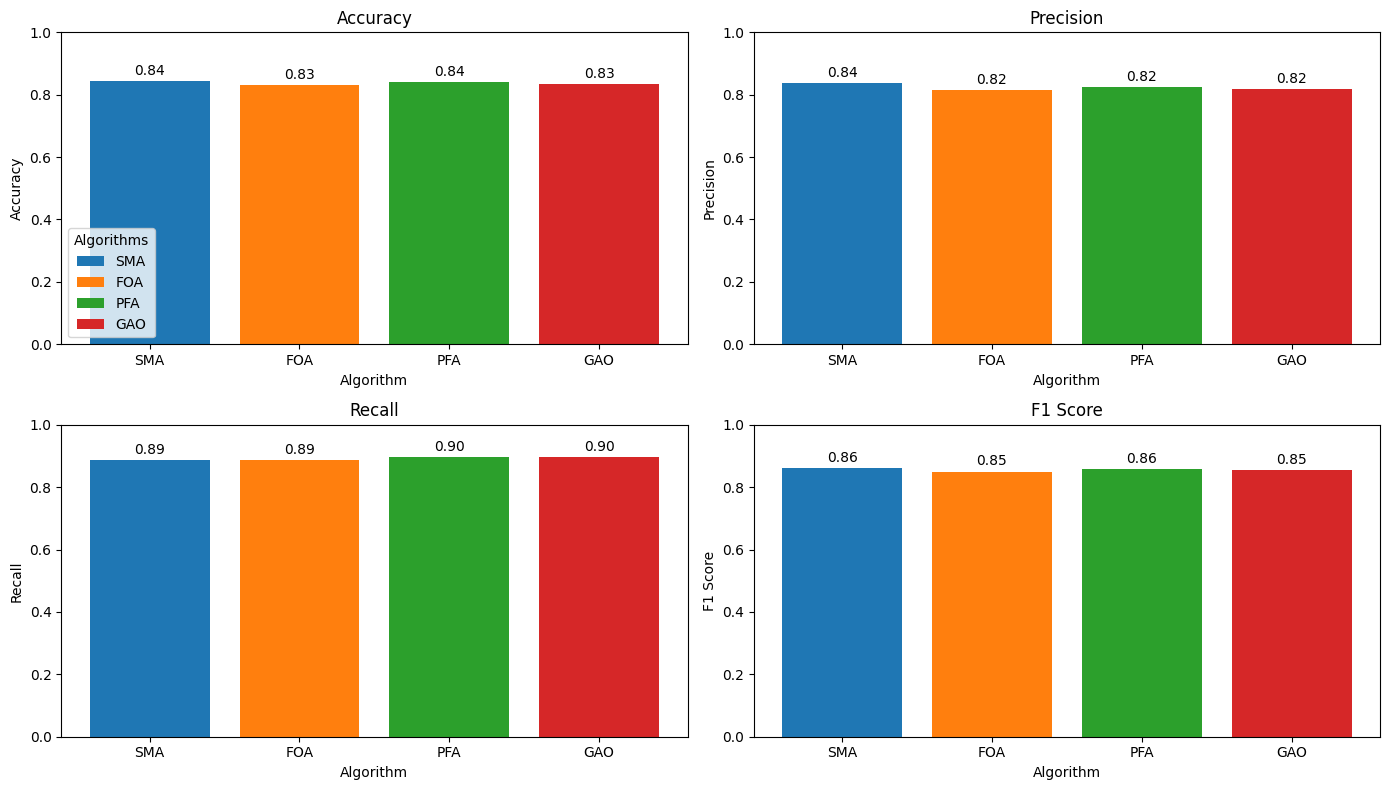

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics for plotting
algorithms_list = list(results.keys())
accuracy = [results[name]['accuracy'] for name in algorithms_list]
precision = [results[name]['precision'] for name in algorithms_list]
recall = [results[name]['recall'] for name in algorithms_list]
f1 = [results[name]['f1_score'] for name in algorithms_list]

metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

# Assign a unique color to each algorithm
color_map = {
    'SMA': '#1f77b4',   # blue
    'FOA': '#ff7f0e',   # orange
    'PFA': '#2ca02c',   # green
    'GAO': '#d62728'    # red
}
bar_colors = [color_map[alg] for alg in algorithms_list]

plt.figure(figsize=(14, 8))
for i, (metric_name, metric_values) in enumerate(metrics.items(), 1):
    plt.subplot(2, 2, i)
    bars = plt.bar(algorithms_list, metric_values, color=bar_colors)
    plt.ylim(0, 1)
    plt.title(metric_name)
    plt.ylabel(metric_name)  # Set y-axis label to metric name
    plt.xlabel('Algorithm')
    for j, v in enumerate(metric_values):
        plt.text(j, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=10)
    # Add legend only to the first plot
    if i == 1:
        plt.legend(bars, algorithms_list, title="Algorithms")

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:09:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:09:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:09:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:09:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


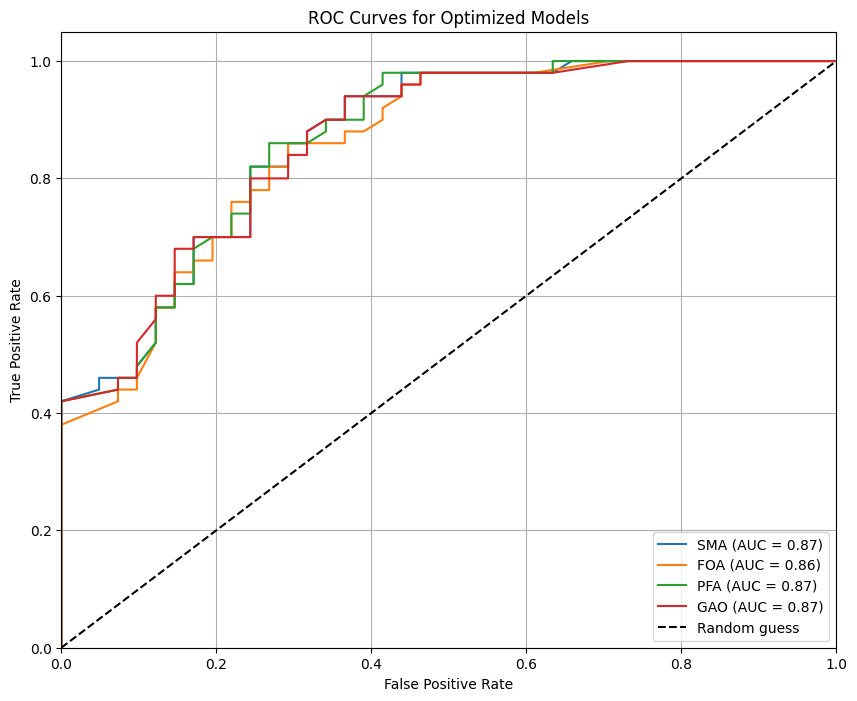

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curves(results, X_test, y_test):
    plt.figure(figsize=(10, 8))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    for (alg_name, result), color in zip(results.items(), colors):
        # Rebuild best model with optimized parameters
        best_params = result['params']
        model = XGBClassifier(
            **best_params,
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='logloss'
        )

        # Train on full training set
        model.fit(X_train, y_train)

        # Get predictions for test set
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, color=color,
                 label=f'{alg_name} (AUC = {roc_auc:.2f})')

    # Plot random guess line
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Optimized Models')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# After running your optimization code, call:
plot_roc_curves(results, X_test, y_test)


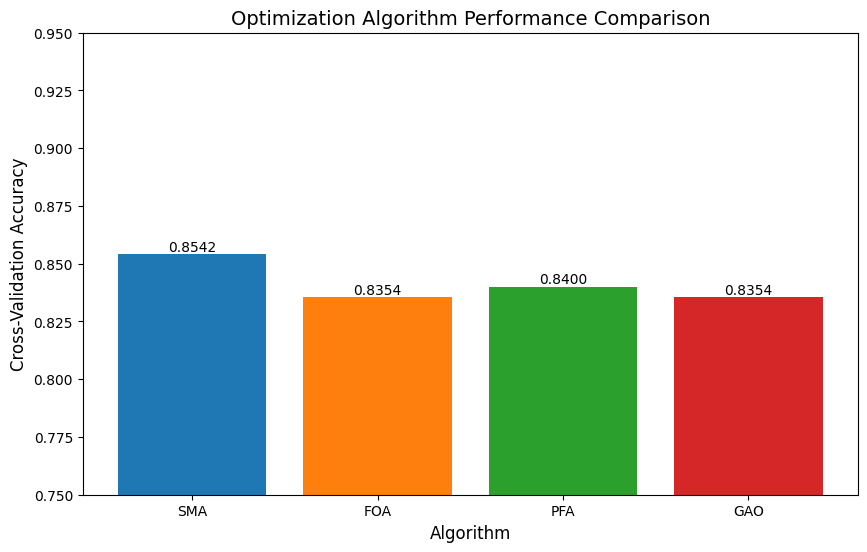

In [ ]:

# Compare results
import matplotlib.pyplot as plt

models = list(results.keys())
accuracies = [results[name]['accuracy'] for name in models]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('Optimization Algorithm Performance Comparison', fontsize=14)
plt.xlabel('Algorithm', fontsize=12)
plt.ylabel('Cross-Validation Accuracy', fontsize=12)
plt.ylim(0.75, 0.95)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom')

plt.show()


In [ ]:
dtc

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Load dataset
data = pd.read_csv("heart-disease.csv", header=None)
col_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
             'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
data.columns = col_names

# Ensure all columns are numeric
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Drop rows with missing values
data = data.dropna()

# Split features and target variable
X = data.drop(['target'], axis=1)
y = data['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Extended hyperparameter search space
dtc_space = {
    'max_depth': (3, 10),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 5),
    'criterion': (0, 1),               # 0 = gini, 1 = entropy
    'splitter': (0, 1),                # 0 = best, 1 = random
    'max_features': (0.5, 1.0),        # fraction
    'ccp_alpha': (0.0, 0.05),
    'class_weight': (0, 1),            # 0 = None, 1 = balanced
    'max_leaf_nodes': (10, 50)
}

# Objective function
def objective(params):
    criterion = 'gini' if int(params[3]) == 0 else 'entropy'
    splitter = 'best' if int(params[4]) == 0 else 'random'
    class_weight = None if int(params[7]) == 0 else 'balanced'

    model = DecisionTreeClassifier(
        max_depth=int(params[0]),
        min_samples_split=int(params[1]),
        min_samples_leaf=int(params[2]),
        criterion=criterion,
        splitter=splitter,
        max_features=params[5],
        ccp_alpha=params[6],
        class_weight=class_weight,
        max_leaf_nodes=int(params[8]),
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    return accuracy_score(y_test, y_pred)

### Optimization Algorithms ###

# Slime Mold Optimization Algorithm (SMA)
def SMA_optimization(search_space, max_iter=20):
    population_size = 5
    population = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                           for _ in range(population_size)])

    for iteration in range(max_iter):
        fitness = np.array([objective(ind) for ind in population])
        sorted_idx = np.argsort(-fitness)
        population = population[sorted_idx]

        a = np.arctanh(1 - (iteration + 1) / max_iter)
        b = 1 - (iteration + 1) / max_iter

        new_population = []
        for i in range(population_size):
            if i < population_size // 2:
                new_pos = population[i] + a * (np.random.rand() * (population[0] - population[i]))
            else:
                new_pos = population[i] + b * (np.random.rand() * (population[i] - population[i - 1]))
            new_population.append(np.clip(new_pos, [v[0] for v in search_space.values()],
                                          [v[1] for v in search_space.values()]))

        population = np.array(new_population)

    best_idx = np.argmax([objective(ind) for ind in population])
    return population[best_idx]

# Forest Optimization Algorithm (FOA)
def FOA_optimization(search_space, max_iter=20):
    num_trees = 5
    trees = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                      for _ in range(num_trees)])

    for _ in range(max_iter):
        fitness = np.array([objective(ind) for ind in trees])
        new_trees = []

        for tree in trees:
            if objective(tree) < np.median(fitness):
                new_trees.append(tree + np.random.normal(0, 0.1, size=len(search_space)))
            else:
                new_trees.append(tree)

        best_idx = np.argmax(fitness)
        new_trees.append(trees[best_idx] + np.random.normal(0, 0.05, size=len(search_space)))

        trees = np.clip(new_trees, [v[0] for v in search_space.values()],
                        [v[1] for v in search_space.values()])

    best_idx = np.argmax([objective(ind) for ind in trees])
    return trees[best_idx]

# Pathfinder Algorithm (PFA)
def PFA_optimization(search_space, max_iter=20):
    group_size = 5
    group = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                      for _ in range(group_size)])

    leader = group[np.argmax([objective(ind) for ind in group])]

    for _ in range(max_iter):
        new_group = []
        for member in group:
            if np.array_equal(member, leader):
                new_pos = member + np.random.rand() * (leader - member)
            else:
                new_pos = member + 2 * np.random.rand() * (leader - member) + \
                          np.random.rand() * (member - leader)
            new_group.append(new_pos)

        group = np.clip(new_group, [v[0] for v in search_space.values()],
                        [v[1] for v in search_space.values()])

        current_leader = group[np.argmax([objective(ind) for ind in group])]
        if objective(current_leader) > objective(leader):
            leader = current_leader

    return leader

# Giant Armadillo Optimization (GAO)
def GAO_optimization(search_space, max_iter=20):
    population_size = 5
    population = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                           for _ in range(population_size)])

    for _ in range(max_iter):
        fitness = np.array([objective(ind) for ind in population])

        for i in range(population_size):
            if np.random.rand() < 0.5:
                population[i] += np.random.normal(0, 0.1, size=len(search_space))

        best_idx = np.argmax(fitness)
        for i in range(population_size):
            if i != best_idx:
                population[i] += np.random.rand() * (population[best_idx] - population[i])

        population = np.clip(population, [v[0] for v in search_space.values()],
                             [v[1] for v in search_space.values()])

    best_idx = np.argmax([objective(ind) for ind in population])
    return population[best_idx]

### Run optimizations and evaluate results ###
algorithms = {
    'SMA': SMA_optimization,
    'FOA': FOA_optimization,
    'PFA': PFA_optimization,
    'GAO': GAO_optimization
}

results = {}
for name, algorithm in algorithms.items():
    best_params = algorithm(dtc_space)
    results[name] = {
        'params': {
            'max_depth': int(best_params[0]),
            'min_samples_split': int(best_params[1]),
            'min_samples_leaf': int(best_params[2]),
            'criterion': 'gini' if int(best_params[3]) == 0 else 'entropy',
            'splitter': 'best' if int(best_params[4]) == 0 else 'random',
            'max_features': round(best_params[5], 2),
            'ccp_alpha': round(best_params[6], 4),
            'class_weight': None if int(best_params[7]) == 0 else 'balanced',
            'max_leaf_nodes': int(best_params[8])
        },
        'accuracy': objective(best_params)
    }
precision = report['1']['precision']
recall = report['1']['recall']
f1_score = report['1']['f1-score']
# Print results
for algo_name, result in results.items():
    print(f"{algo_name}: Best Parameters: {result['params']}, Accuracy: {result['accuracy']:.4f}")


SMA: Best Parameters: {'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'entropy', 'splitter': 'best', 'max_features': np.float64(0.61), 'ccp_alpha': np.float64(0.0235), 'class_weight': None, 'max_leaf_nodes': 47}, Accuracy: 0.8242
FOA: Best Parameters: {'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'gini', 'splitter': 'best', 'max_features': np.float64(0.62), 'ccp_alpha': np.float64(0.0), 'class_weight': None, 'max_leaf_nodes': 19}, Accuracy: 0.8242
PFA: Best Parameters: {'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 2, 'criterion': 'gini', 'splitter': 'best', 'max_features': np.float64(0.64), 'ccp_alpha': np.float64(0.006), 'class_weight': None, 'max_leaf_nodes': 34}, Accuracy: 0.8242
GAO: Best Parameters: {'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 3, 'criterion': 'gini', 'splitter': 'best', 'max_features': np.float64(0.56), 'ccp_alpha': np.float64(0.0137), 'class_weight': None, 'max_leaf_nodes':

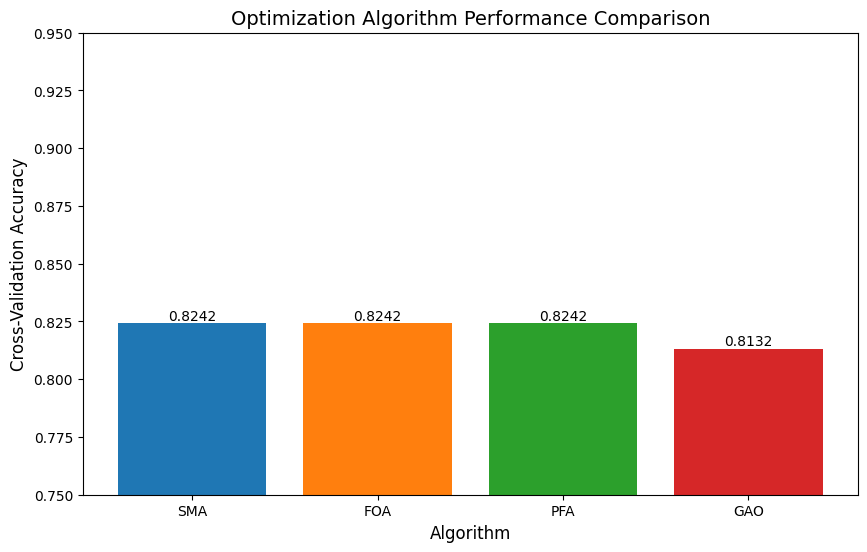

In [ ]:
# Compare results
import matplotlib.pyplot as plt

models = list(results.keys())
accuracies = [results[name]['accuracy'] for name in models]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('Optimization Algorithm Performance Comparison', fontsize=14)
plt.xlabel('Algorithm', fontsize=12)
plt.ylabel('Cross-Validation Accuracy', fontsize=12)
plt.ylim(0.75, 0.95)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom')

plt.show()

rfc

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Load dataset
data = pd.read_csv("heart-disease.csv", header=None)
col_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
             'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
data.columns = col_names

# Ensure all columns are numeric
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Drop rows with missing values (if any)
data = data.dropna()

# Split features and target variable
X = data.drop(['target'], axis=1)
y = data['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Define search space for RFC hyperparameters
rfc_space = {
    'n_estimators': (10, 100),          # Number of trees
    'max_depth': (3, 15),               # Max depth of tree
    'min_samples_split': (2, 10),       # Min samples to split a node
    'min_samples_leaf': (1, 5)          # Min samples at a leaf
}

# Objective function to evaluate model performance
def objective(params):
    model = RandomForestClassifier(
        n_estimators=int(params[0]),
        max_depth=int(params[1]),
        min_samples_split=int(params[2]),
        min_samples_leaf=int(params[3]),
        random_state=42
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy').mean()

### Optimization Algorithms ###
# (All the optimization functions remain the same. Just adapt them for the extra param.)

# SMA
def SMA_optimization(search_space, max_iter=20):
    population_size = 5
    population = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                          for _ in range(population_size)])

    for iteration in range(max_iter):
        fitness = np.array([objective(ind) for ind in population])
        sorted_idx = np.argsort(-fitness)
        population = population[sorted_idx]

        a = np.arctanh(1 - (iteration+1)/max_iter)
        b = 1 - (iteration+1)/max_iter

        new_population = []
        for i in range(population_size):
            if i < population_size // 2:
                new_pos = population[i] + a * (np.random.rand() * (population[0] - population[i]))
            else:
                new_pos = population[i] + b * (np.random.rand() * (population[i] - population[i-1]))
            new_population.append(np.clip(new_pos,
                                          [v[0] for v in search_space.values()],
                                          [v[1] for v in search_space.values()]))
        population = np.array(new_population)

    best_idx = np.argmax([objective(ind) for ind in population])
    return population[best_idx]

# FOA
def FOA_optimization(search_space, max_iter=20):
    num_trees = 5
    trees = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                     for _ in range(num_trees)])

    for _ in range(max_iter):
        fitness = np.array([objective(ind) for ind in trees])

        new_trees = []
        for tree in trees:
            if objective(tree) < np.median(fitness):
                new_trees.append(tree + np.random.normal(0, 0.1, size=len(search_space)))
            else:
                new_trees.append(tree)

        best_idx = np.argmax(fitness)
        new_trees.append(trees[best_idx] + np.random.normal(0, 0.05, size=len(search_space)))

        trees = np.clip(new_trees, [v[0] for v in search_space.values()],
                       [v[1] for v in search_space.values()])

    best_idx = np.argmax([objective(ind) for ind in trees])
    return trees[best_idx]

# PFA
def PFA_optimization(search_space, max_iter=20):
    group_size = 5
    group = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                     for _ in range(group_size)])

    leader = group[np.argmax([objective(ind) for ind in group])]

    for _ in range(max_iter):
        new_group = []
        for member in group:
            if np.array_equal(member, leader):
                new_pos = member + np.random.rand() * (leader - member)
            else:
                new_pos = member + 2*np.random.rand()*(leader - member) + \
                         np.random.rand()*(member - leader)
            new_group.append(new_pos)

        group = np.clip(new_group, [v[0] for v in search_space.values()],
                       [v[1] for v in search_space.values()])

        current_leader = group[np.argmax([objective(ind) for ind in group])]
        if objective(current_leader) > objective(leader):
            leader = current_leader

    return leader

# GAO
def GAO_optimization(search_space, max_iter=20):
    population_size = 5
    population = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                          for _ in range(population_size)])

    for _ in range(max_iter):
        fitness = np.array([objective(ind) for ind in population])

        for i in range(population_size):
            if np.random.rand() < 0.5:
                population[i] += np.random.normal(0, 0.1, size=len(search_space))

        best_idx = np.argmax(fitness)
        for i in range(population_size):
            if i != best_idx:
                population[i] += np.random.rand() * (population[best_idx] - population[i])

        population = np.clip(population,
                             [v[0] for v in search_space.values()],
                             [v[1] for v in search_space.values()])

    best_idx = np.argmax([objective(ind) for ind in population])
    return population[best_idx]

# Run optimizations and evaluate results
algorithms = {
    'SMA': SMA_optimization,
    'FOA': FOA_optimization,
    'PFA': PFA_optimization,
    'GAO': GAO_optimization
}

results = {}
for name, algorithm in algorithms.items():
    best_params = algorithm(rfc_space)
    results[name] = {
        'params': {
            'n_estimators': int(best_params[0]),
            'max_depth': int(best_params[1]),
            'min_samples_split': int(best_params[2]),
            'min_samples_leaf': int(best_params[3])
        },
        'accuracy': objective(best_params)
    }

# Print results
for algo_name, result in results.items():
    print(f"{algo_name}: Best Parameters: {result['params']}, Accuracy: {result['accuracy']:.4f}")


SMA: Best Parameters: {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 4}, Accuracy: 0.8791
FOA: Best Parameters: {'n_estimators': 95, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1}, Accuracy: 0.8352
PFA: Best Parameters: {'n_estimators': 18, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2}, Accuracy: 0.8462
GAO: Best Parameters: {'n_estimators': 43, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 2}, Accuracy: 0.8571


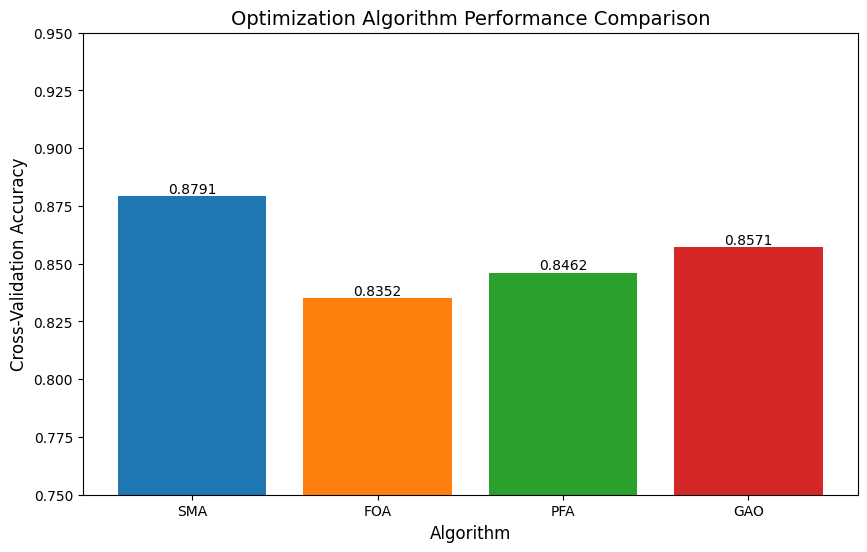

In [ ]:
# Compare results
import matplotlib.pyplot as plt

models = list(results.keys())
accuracies = [results[name]['accuracy'] for name in models]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('Optimization Algorithm Performance Comparison', fontsize=14)
plt.xlabel('Algorithm', fontsize=12)
plt.ylabel('Cross-Validation Accuracy', fontsize=12)
plt.ylim(0.75, 0.95)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom')

plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Load dataset
data = pd.read_csv("heart-disease.csv", header=None)
col_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
             'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
data.columns = col_names

# Ensure all columns are numeric
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Drop rows with missing values (if any)
data = data.dropna()

# Split features and target variable
X = data.drop(['target'], axis=1)
y = data['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Define search space for RFC hyperparameters
rfc_space = {
    'n_estimators': (10, 100),          # Number of trees
    'max_depth': (3, 15),               # Max depth of tree
    'min_samples_split': (2, 10),       # Min samples to split a node
    'min_samples_leaf': (1, 5)          # Min samples at a leaf
}

# Objective function to evaluate model performance (cross-validated accuracy)
def objective(params):
    model = RandomForestClassifier(
        n_estimators=int(params[0]),
        max_depth=int(params[1]),
        min_samples_split=int(params[2]),
        min_samples_leaf=int(params[3]),
        random_state=42
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy').mean()

### Optimization Algorithms ###

# SMA
def SMA_optimization(search_space, max_iter=20):
    population_size = 5
    population = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                          for _ in range(population_size)])

    for iteration in range(max_iter):
        fitness = np.array([objective(ind) for ind in population])
        sorted_idx = np.argsort(-fitness)
        population = population[sorted_idx]

        a = np.arctanh(1 - (iteration+1)/max_iter)
        b = 1 - (iteration+1)/max_iter

        new_population = []
        for i in range(population_size):
            if i < population_size // 2:
                new_pos = population[i] + a * (np.random.rand() * (population[0] - population[i]))
            else:
                new_pos = population[i] + b * (np.random.rand() * (population[i] - population[i-1]))
            new_population.append(np.clip(new_pos,
                                          [v[0] for v in search_space.values()],
                                          [v[1] for v in search_space.values()]))
        population = np.array(new_population)

    best_idx = np.argmax([objective(ind) for ind in population])
    return population[best_idx]

# FOA
def FOA_optimization(search_space, max_iter=20):
    num_trees = 5
    trees = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                     for _ in range(num_trees)])

    for _ in range(max_iter):
        fitness = np.array([objective(ind) for ind in trees])

        new_trees = []
        for tree in trees:
            if objective(tree) < np.median(fitness):
                new_trees.append(tree + np.random.normal(0, 0.1, size=len(search_space)))
            else:
                new_trees.append(tree)

        best_idx = np.argmax(fitness)
        new_trees.append(trees[best_idx] + np.random.normal(0, 0.05, size=len(search_space)))

        trees = np.clip(new_trees, [v[0] for v in search_space.values()],
                       [v[1] for v in search_space.values()])

    best_idx = np.argmax([objective(ind) for ind in trees])
    return trees[best_idx]

# PFA
def PFA_optimization(search_space, max_iter=20):
    group_size = 5
    group = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                     for _ in range(group_size)])

    leader = group[np.argmax([objective(ind) for ind in group])]

    for _ in range(max_iter):
        new_group = []
        for member in group:
            if np.array_equal(member, leader):
                new_pos = member + np.random.rand() * (leader - member)
            else:
                new_pos = member + 2*np.random.rand()*(leader - member) + \
                         np.random.rand()*(member - leader)
            new_group.append(new_pos)

        group = np.clip(new_group, [v[0] for v in search_space.values()],
                       [v[1] for v in search_space.values()])

        current_leader = group[np.argmax([objective(ind) for ind in group])]
        if objective(current_leader) > objective(leader):
            leader = current_leader

    return leader

# GAO
def GAO_optimization(search_space, max_iter=20):
    population_size = 5
    population = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                          for _ in range(population_size)])

    for _ in range(max_iter):
        fitness = np.array([objective(ind) for ind in population])

        for i in range(population_size):
            if np.random.rand() < 0.5:
                population[i] += np.random.normal(0, 0.1, size=len(search_space))

        best_idx = np.argmax(fitness)
        for i in range(population_size):
            if i != best_idx:
                population[i] += np.random.rand() * (population[best_idx] - population[i])

        population = np.clip(population,
                             [v[0] for v in search_space.values()],
                             [v[1] for v in search_space.values()])

    best_idx = np.argmax([objective(ind) for ind in population])
    return population[best_idx]

# Run optimizations and evaluate results
algorithms = {
    'SMA': SMA_optimization,
    'FOA': FOA_optimization,
    'PFA': PFA_optimization,
    'GAO': GAO_optimization
}

results = {}
for name, algorithm in algorithms.items():
    best_params = algorithm(rfc_space)
    # Train final model on train set with best params
    final_model = RandomForestClassifier(
        n_estimators=int(best_params[0]),
        max_depth=int(best_params[1]),
        min_samples_split=int(best_params[2]),
        min_samples_leaf=int(best_params[3]),
        random_state=42
    )
    final_model.fit(X_train, y_train)
    y_pred = final_model.predict(X_test)
    # Compute all metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    results[name] = {
        'params': {
            'n_estimators': int(best_params[0]),
            'max_depth': int(best_params[1]),
            'min_samples_split': int(best_params[2]),
            'min_samples_leaf': int(best_params[3])
        },
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

# Print results
for algo_name, result in results.items():
    print(f"{algo_name}: Best Parameters: {result['params']}, "
          f"Accuracy: {result['accuracy']:.4f}, "
          f"Precision: {result['precision']:.4f}, "
          f"Recall: {result['recall']:.4f}, "
          f"F1-score: {result['f1_score']:.4f}")


SMA: Best Parameters: {'n_estimators': 64, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 5}, Accuracy: 0.8462, Precision: 0.8475, Recall: 0.8462, F1-score: 0.8452
FOA: Best Parameters: {'n_estimators': 33, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 2}, Accuracy: 0.8242, Precision: 0.8242, Recall: 0.8242, F1-score: 0.8242
PFA: Best Parameters: {'n_estimators': 76, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 4}, Accuracy: 0.8242, Precision: 0.8240, Recall: 0.8242, F1-score: 0.8237
GAO: Best Parameters: {'n_estimators': 25, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2}, Accuracy: 0.8571, Precision: 0.8578, Recall: 0.8571, F1-score: 0.8565


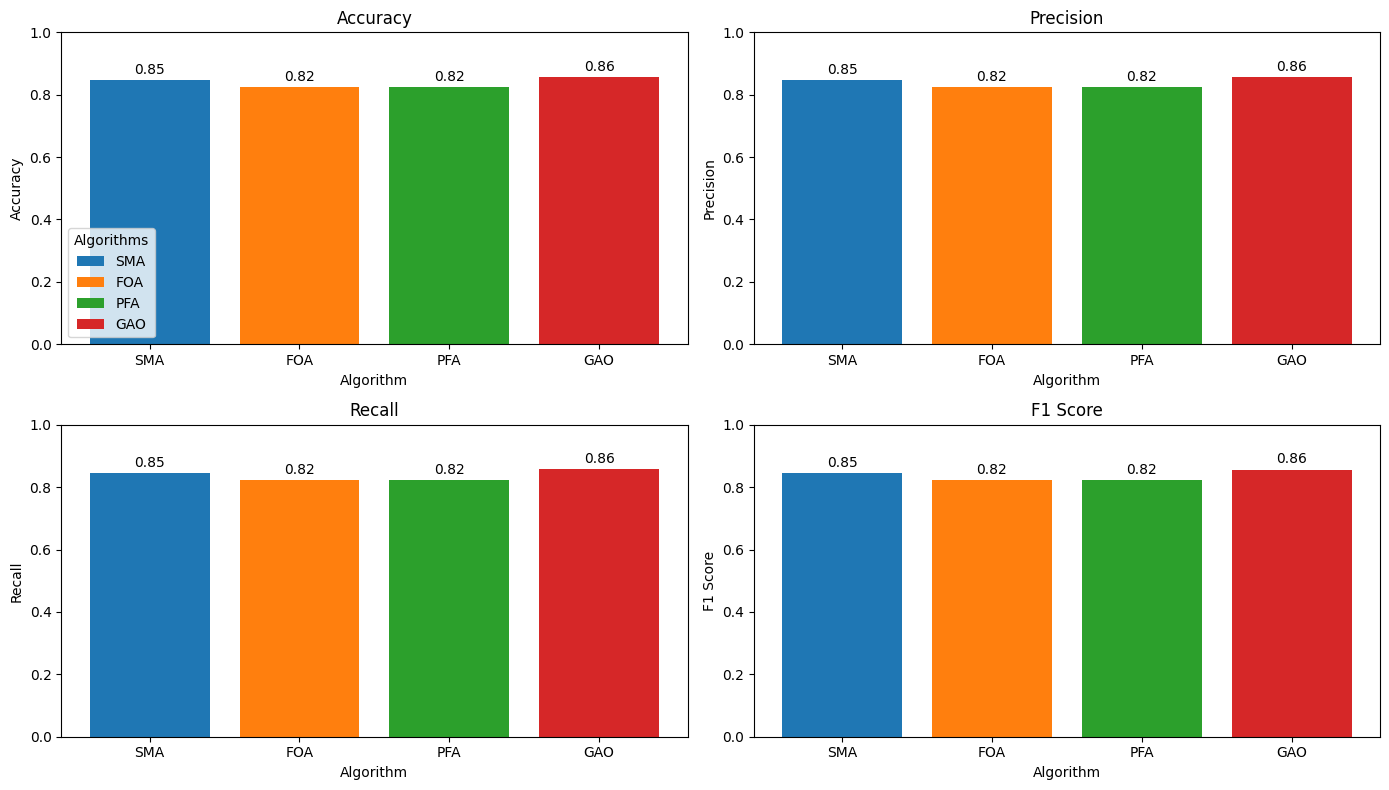

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics for plotting
algorithms_list = list(results.keys())
accuracy = [results[name]['accuracy'] for name in algorithms_list]
precision = [results[name]['precision'] for name in algorithms_list]
recall = [results[name]['recall'] for name in algorithms_list]
f1 = [results[name]['f1_score'] for name in algorithms_list]

metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

# Assign a unique color to each algorithm
color_map = {
    'SMA': '#1f77b4',   # blue
    'FOA': '#ff7f0e',   # orange
    'PFA': '#2ca02c',   # green
    'GAO': '#d62728'    # red
}
bar_colors = [color_map[alg] for alg in algorithms_list]

plt.figure(figsize=(14, 8))
for i, (metric_name, metric_values) in enumerate(metrics.items(), 1):
    plt.subplot(2, 2, i)
    bars = plt.bar(algorithms_list, metric_values, color=bar_colors)
    plt.ylim(0, 1)
    plt.title(metric_name)
    plt.ylabel(metric_name)  # Set y-axis label to metric name
    plt.xlabel('Algorithm')
    for j, v in enumerate(metric_values):
        plt.text(j, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=10)
    # Add legend only to the first plot
    if i == 1:
        plt.legend(bars, algorithms_list, title="Algorithms")

plt.tight_layout()
plt.show()


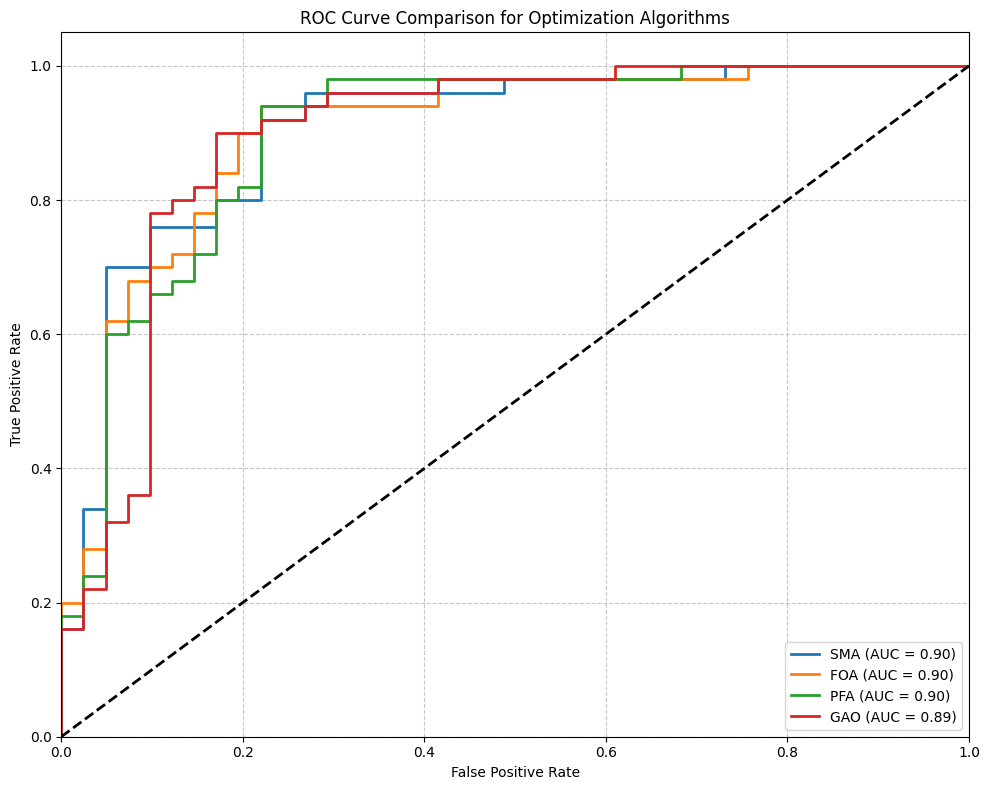

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Create ROC curves for each algorithm
plt.figure(figsize=(10, 8))

# Get the unique classes from y_test
classes = np.unique(y_test)
# Binarize the output for multi-class ROC if needed
if len(classes) > 2:
    y_test_bin = label_binarize(y_test, classes=classes)
    n_classes = y_test_bin.shape[1]
else:
    # For binary classification
    y_test_bin = y_test
    n_classes = 1

# Plot ROC curve for each algorithm
for name in algorithms_list:
    # Create and train model with the best parameters
    best_params = results[name]['params']
    model = RandomForestClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=42
    )
    model.fit(X_train, y_train)

    # Get prediction probabilities
    y_score = model.predict_proba(X_test)

    # For binary classification
    if n_classes == 1:
        fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2,
                 label=f'{name} (AUC = {roc_auc:.2f})')
    else:
        # For multi-class, compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test_bin.ravel(),
                               np.concatenate([y_score[:, i] for i in range(n_classes)]).ravel())
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2,
                 label=f'{name} (AUC = {roc_auc:.2f})')

# Add diagonal line representing random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Style the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for Optimization Algorithms')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Load and preprocess data
def load_data():
    df = pd.read_csv("heart-disease.csv", header=None)
    col_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
    df.columns = col_names
    df = df.apply(pd.to_numeric, errors='coerce').dropna()
    X = df.drop(['target', 'restecg', 'sex', 'chol', 'fbs', 'trestbps', 'slope', 'exang'], axis=1)
    y = df['target'].astype(int)
    return train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train, X_test, y_train, y_test = load_data()

# ================== XGBoost Implementation ==================
xgb_space = {
    'max_depth': (3, 10),
    'learning_rate': (0.1, 0.3),
    'n_estimators': (50, 200),
    'alpha': (0, 10)
}

def xgb_objective(params):
    model = XGBClassifier(
        max_depth=int(params[0]),
        learning_rate=params[1],
        n_estimators=int(params[2]),
        alpha=params[3],
        objective='binary:logistic'
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy').mean()

def xgb_SMA(search_space, max_iter=20):
    population_size = 5
    population = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                          for _ in range(population_size)])

    for iteration in range(max_iter):
        fitness = np.array([xgb_objective(ind) for ind in population])
        sorted_idx = np.argsort(-fitness)
        population = population[sorted_idx]

        a = np.arctanh(1 - (iteration+1)/max_iter)
        b = 1 - (iteration+1)/max_iter

        new_population = []
        for i in range(population_size):
            if i < population_size//2:
                new_pos = population[i] + a * (np.random.rand() * (population[0] - population[i]))
            else:
                new_pos = population[i] + b * (np.random.rand() * (population[i] - population[i-1]))
            new_population.append(np.clip(new_pos,
                [v[0] for v in search_space.values()],
                [v[1] for v in search_space.values()]))

        population = np.array(new_population)

    best_idx = np.argmax([xgb_objective(ind) for ind in population])
    return population[best_idx]

# Similar implementations for FOA, PFA, GAO following same pattern

# ================== Decision Tree Implementation ==================
dtc_space = {
    'max_depth': (3, 15),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 5),
    'max_features': (0.5, 1.0)
}

def dtc_objective(params):
    model = DecisionTreeClassifier(
        max_depth=int(params[0]),
        min_samples_split=int(params[1]),
        min_samples_leaf=int(params[2]),
        max_features=params[3],
        random_state=42
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy').mean()

# Optimization algorithms similar to XGBoost implementation

# ================== Random Forest Implementation ==================
rfc_space = {
    'n_estimators': (10, 100),
    'max_depth': (3, 15),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 5)
}

def rfc_objective(params):
    model = RandomForestClassifier(
        n_estimators=int(params[0]),
        max_depth=int(params[1]),
        min_samples_split=int(params[2]),
        min_samples_leaf=int(params[3]),
        random_state=42
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy').mean()

# ================== Run Optimizations ==================
def run_optimizations(model_name, space, objective):
    algorithms = {
        'SMA': xgb_SMA if model_name == 'XGBoost' else None,
        # Add other algorithms
    }

    results = {}
    for algo_name, algorithm in algorithms.items():
        best_params = algorithm(space)
        model = {
            'XGBoost': XGBClassifier(
                max_depth=int(best_params[0]),
                learning_rate=best_params[1],
                n_estimators=int(best_params[2]),
                alpha=best_params[3],
                objective='binary:logistic'
            ),
            # Add other model initializations
        }[model_name]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        results[algo_name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred)
        }
    return results

# ================== Visualization ==================
def plot_results(results):
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        for model, data in results.items():
            plt.bar(model, data[metric], label=model)
        plt.title(metric.upper())
        plt.ylim(0, 1)
        plt.legend()
    plt.tight_layout()
    plt.show()

# Execute and compare all models
final_results = {
    'XGBoost': run_optimizations('XGBoost', xgb_space, xgb_objective),
    'DecisionTree': run_optimizations('DecisionTree', dtc_space, dtc_objective),
    'RandomForest': run_optimizations('RandomForest', rfc_space, rfc_objective)
}

plot_results(final_results)


TypeError: 'NoneType' object is not callable

# **Final**


## XGBC

Optimizing XGBoost with SMA...
  Accuracy: 0.7912
  Precision: 0.7719
  Recall: 0.8800
  F1-score: 0.8224
  AUC: 0.8632
  Parameters: {'max_depth': 10, 'learning_rate': np.float64(0.1), 'n_estimators': 50, 'alpha': np.float64(5.163254991897119)}

Optimizing XGBoost with FOA...
  Accuracy: 0.7802
  Precision: 0.7679
  Recall: 0.8600
  F1-score: 0.8113
  AUC: 0.8659
  Parameters: {'max_depth': 7, 'learning_rate': np.float64(0.1), 'n_estimators': 115, 'alpha': np.float64(6.103498679770693)}

Optimizing XGBoost with PFA...
  Accuracy: 0.7802
  Precision: 0.7679
  Recall: 0.8600
  F1-score: 0.8113
  AUC: 0.8671
  Parameters: {'max_depth': 5, 'learning_rate': np.float64(0.1453621206226105), 'n_estimators': 51, 'alpha': np.float64(4.155727365120923)}

Optimizing XGBoost with GAO...
  Accuracy: 0.7802
  Precision: 0.7679
  Recall: 0.8600
  F1-score: 0.8113
  AUC: 0.8649
  Parameters: {'max_depth': 7, 'learning_rate': np.float64(0.28406002563412563), 'n_estimators': 113, 'alpha': np.float64(6.0

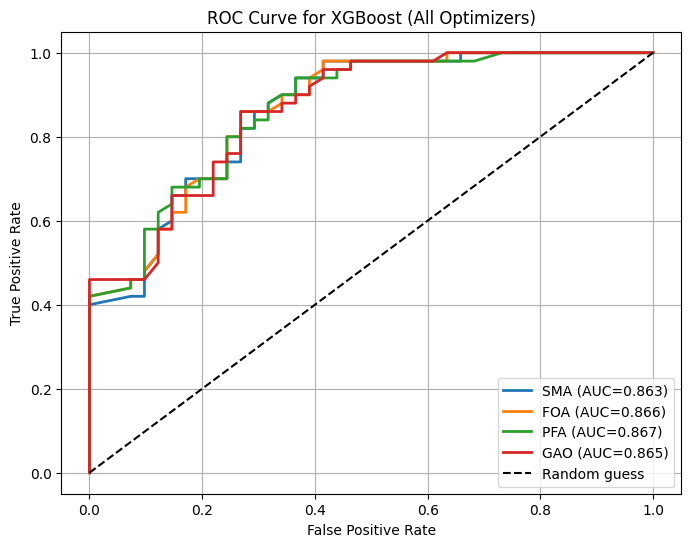

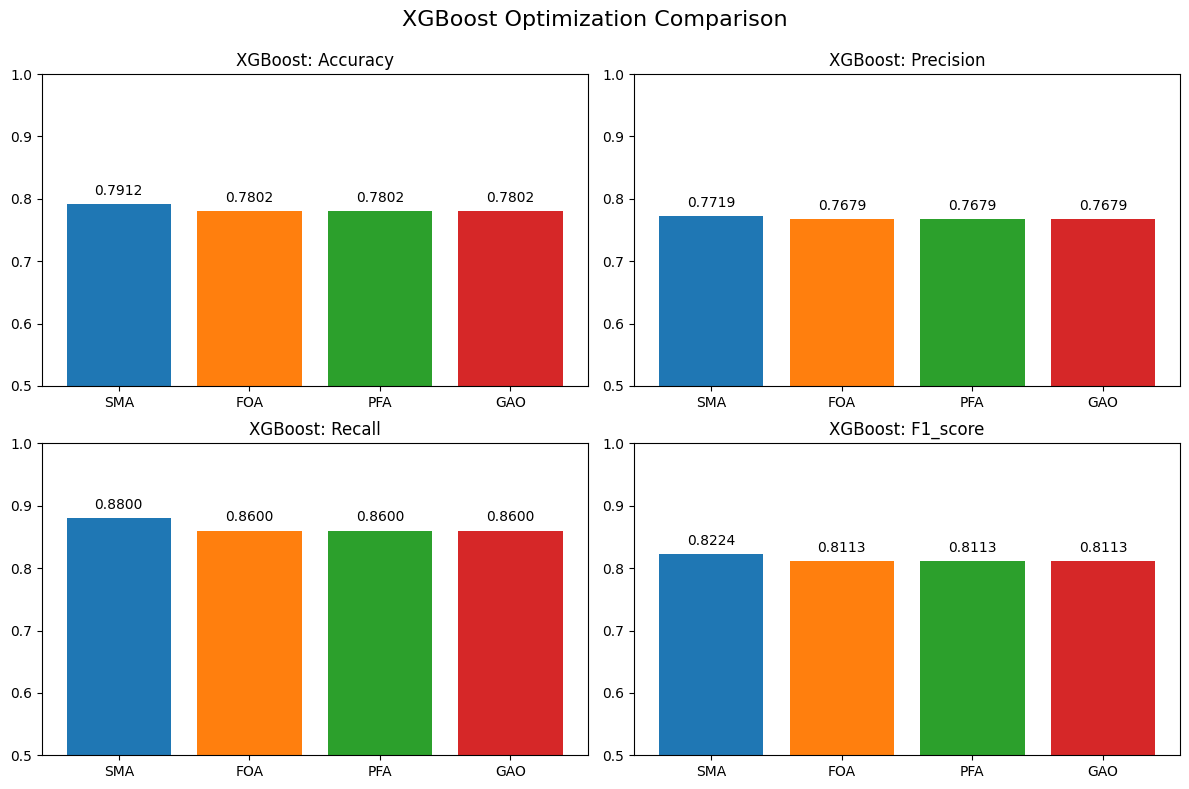

Optimization Results Summary:
--------------------------------------------------------------------------------
Optimizer  | Accuracy   | Precision  | Recall     | F1-score   | Parameters
--------------------------------------------------------------------------------
SMA        | 0.7912     | 0.7719     | 0.8800     | 0.8224     | depth=10, lr=0.100, est=50, alpha=5.163
FOA        | 0.7802     | 0.7679     | 0.8600     | 0.8113     | depth=7, lr=0.100, est=115, alpha=6.103
PFA        | 0.7802     | 0.7679     | 0.8600     | 0.8113     | depth=5, lr=0.145, est=51, alpha=4.156
GAO        | 0.7802     | 0.7679     | 0.8600     | 0.8113     | depth=7, lr=0.284, est=113, alpha=6.049


In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load and preprocess data
df = pd.read_csv('heart-disease.csv')

# Drop columns as in the reference
X = df.drop(['target', 'restecg', 'sex', 'chol', 'fbs', 'trestbps', 'slope', 'exang'], axis=1)
y = df['target'].astype(int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define search space for XGBoost parameters
xgb_space = {
    'max_depth': (3, 10),
    'learning_rate': (0.1, 0.3),
    'n_estimators': (50, 200),
    'alpha': (0, 10)
}

# Objective function to maximize
def objective(params):
    model = XGBClassifier(
        max_depth=int(params[0]),
        learning_rate=params[1],
        n_estimators=int(params[2]),
        alpha=params[3],
        objective='binary:logistic',
        eval_metric='logloss'
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy').mean()

# 1. Slime Mold Algorithm (SMA)
def SMA_optimization(search_space, max_iter=20):
    population_size = 5
    population = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                          for _ in range(population_size)])

    for iteration in range(max_iter):
        fitness = np.array([objective(ind) for ind in population])
        sorted_idx = np.argsort(-fitness)
        population = population[sorted_idx]

        # Update weights
        a = np.arctanh(1 - (iteration+1)/max_iter)
        b = 1 - (iteration+1)/max_iter
        weights = 1 + np.random.rand() * np.log10((fitness[sorted_idx] - fitness.min()) /
                  (fitness.max() - fitness.min() + 1e-10) + 1)

        # Update positions
        new_population = []
        for i in range(population_size):
            if i < population_size//2:
                new_pos = population[i] + a * (np.random.rand() *
                          (population[0] - population[i]))
            else:
                new_pos = population[i] + b * (np.random.rand() *
                          (population[i] - population[i-1]))
            new_population.append(np.clip(new_pos, [v[0] for v in search_space.values()],
                                        [v[1] for v in search_space.values()]))

        population = np.array(new_population)

    best_idx = np.argmax([objective(ind) for ind in population])
    return population[best_idx]

# 2. Forest Optimization Algorithm (FOA)
def FOA_optimization(search_space, max_iter=20):
    num_trees = 5
    trees = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                     for _ in range(num_trees)])

    for _ in range(max_iter):
        fitness = np.array([objective(ind) for ind in trees])
        best_idx = np.argmax(fitness)

        # Local seeding
        new_trees = []
        for tree in trees:
            if objective(tree) < np.median(fitness):
                new_trees.append(tree + np.random.normal(0, 0.1, size=len(search_space)))
            else:
                new_trees.append(tree)

        # Global seeding
        new_trees.append(trees[best_idx] + np.random.normal(0, 0.05, size=len(search_space)))

        trees = np.clip(new_trees, [v[0] for v in search_space.values()],
                       [v[1] for v in search_space.values()])

    best_idx = np.argmax([objective(ind) for ind in trees])
    return trees[best_idx]

# 3. Pathfinder Algorithm (PFA)
def PFA_optimization(search_space, max_iter=20):
    group_size = 5
    group = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                     for _ in range(group_size)])
    leader = group[np.argmax([objective(ind) for ind in group])]

    for _ in range(max_iter):
        # Update positions
        new_group = []
        for member in group:
            if np.array_equal(member, leader):
                new_pos = member + np.random.rand() * (leader - member)
            else:
                new_pos = member + 2*np.random.rand()*(leader - member) + \
                         np.random.rand()*(member - leader)
            new_group.append(new_pos)

        group = np.clip(new_group, [v[0] for v in search_space.values()],
                       [v[1] for v in search_space.values()])

        # Update leader
        current_leader = group[np.argmax([objective(ind) for ind in group])]
        if objective(current_leader) > objective(leader):
            leader = current_leader

    return leader

# 4. Giant Armadillo Optimization (GAO)
def GAO_optimization(search_space, max_iter=20):
    population_size = 5
    population = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                          for _ in range(population_size)])

    for _ in range(max_iter):
        fitness = np.array([objective(ind) for ind in population])

        # Excavation phase
        for i in range(population_size):
            if np.random.rand() < 0.5:
                population[i] += np.random.normal(0, 0.1, size=len(search_space))

        # Foraging phase
        best_idx = np.argmax(fitness)
        for i in range(population_size):
            if i != best_idx:
                population[i] += np.random.rand() * (population[best_idx] - population[i])

        population = np.clip(population, [v[0] for v in search_space.values()],
                            [v[1] for v in search_space.values()])

    best_idx = np.argmax([objective(ind) for ind in population])
    return population[best_idx]

# Run all four optimizations for XGBoost
optimizers = {
    'SMA': SMA_optimization,
    'FOA': FOA_optimization,
    'PFA': PFA_optimization,
    'GAO': GAO_optimization
}

results = {}

plt.figure(figsize=(8, 6))  # For ROC curves

for name, optimizer in optimizers.items():
    print(f"Optimizing XGBoost with {name}...")
    best_params = optimizer(xgb_space)

    # Create model with optimized parameters
    model = XGBClassifier(
        max_depth=int(best_params[0]),
        learning_rate=best_params[1],
        n_estimators=int(best_params[2]),
        alpha=best_params[3],
        objective='binary:logistic',
        eval_metric='logloss'
    )

    # Train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # <--- ADD THIS LINE

    # Calculate metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)         # <--- ADD THIS LINE
    fpr, tpr, _ = roc_curve(y_test, y_proba)     # <--- ADD THIS LINE

    # Store results
    results[name] = {
        'params': {
            'max_depth': int(best_params[0]),
            'learning_rate': best_params[1],
            'n_estimators': int(best_params[2]),
            'alpha': best_params[3]
        },
        'accuracy': accuracy,
        'precision': report['1']['precision'],
        'recall': report['1']['recall'],
        'f1_score': report['1']['f1-score'],
        'auc': auc
    }

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {report['1']['precision']:.4f}")
    print(f"  Recall: {report['1']['recall']:.4f}")
    print(f"  F1-score: {report['1']['f1-score']:.4f}")
    print(f"  AUC: {auc:.4f}")                  # <--- ADD THIS LINE
    print(f"  Parameters: {results[name]['params']}")
    print("")

    # --- Plot ROC curve for this optimizer ---
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC={auc:.3f})')

# --- Finalize ROC plot ---
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost (All Optimizers)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot results
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
optimizer_names = list(results.keys())

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    values = [results[name][metric] for name in optimizer_names]
    bars = axs[i].bar(optimizer_names, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    axs[i].set_title(f'XGBoost: {metric.capitalize()}')
    axs[i].set_ylim(0.5, 1.0)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        axs[i].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.suptitle('XGBoost Optimization Comparison', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# Create a comparison table
print("Optimization Results Summary:")
print("-" * 80)
print(f"{'Optimizer':<10} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10} | {'F1-score':<10} | Parameters")
print("-" * 80)
for name in optimizer_names:
    params_str = f"depth={results[name]['params']['max_depth']}, " + \
                 f"lr={results[name]['params']['learning_rate']:.3f}, " + \
                 f"est={results[name]['params']['n_estimators']}, " + \
                 f"alpha={results[name]['params']['alpha']:.3f}"

    print(f"{name:<10} | {results[name]['accuracy']:<10.4f} | " +
          f"{results[name]['precision']:<10.4f} | {results[name]['recall']:<10.4f} | " +
          f"{results[name]['f1_score']:<10.4f} | {params_str}")


## DTC

Optimizing DTC with SMA...
  Accuracy: 0.7802
  Precision: 0.7586
  Recall: 0.8800
  F1-score: 0.8148
  AUC: 0.7885
  Parameters: {'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 5, 'criterion': 'entropy', 'splitter': 'random', 'max_features': np.float64(1.0), 'ccp_alpha': np.float64(0.05), 'class_weight': None, 'max_leaf_nodes': 20}

Optimizing DTC with FOA...
  Accuracy: 0.7802
  Precision: 0.7778
  Recall: 0.8400
  F1-score: 0.8077
  AUC: 0.8373
  Parameters: {'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'entropy', 'splitter': 'random', 'max_features': np.float64(1.0), 'ccp_alpha': np.float64(0.007733907719840782), 'class_weight': 'balanced', 'max_leaf_nodes': 33}

Optimizing DTC with PFA...
  Accuracy: 0.8022
  Precision: 0.7581
  Recall: 0.9400
  F1-score: 0.8393
  AUC: 0.7727
  Parameters: {'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'entropy', 'splitter': 'best', 'max_features': np.float64(0.720951417080

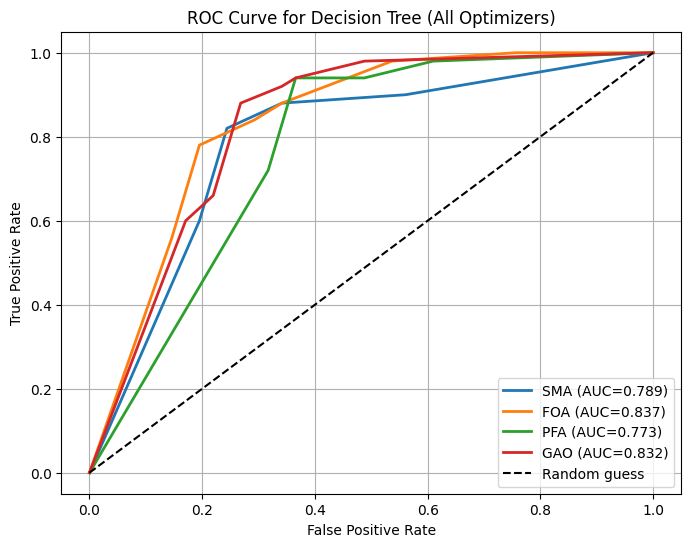

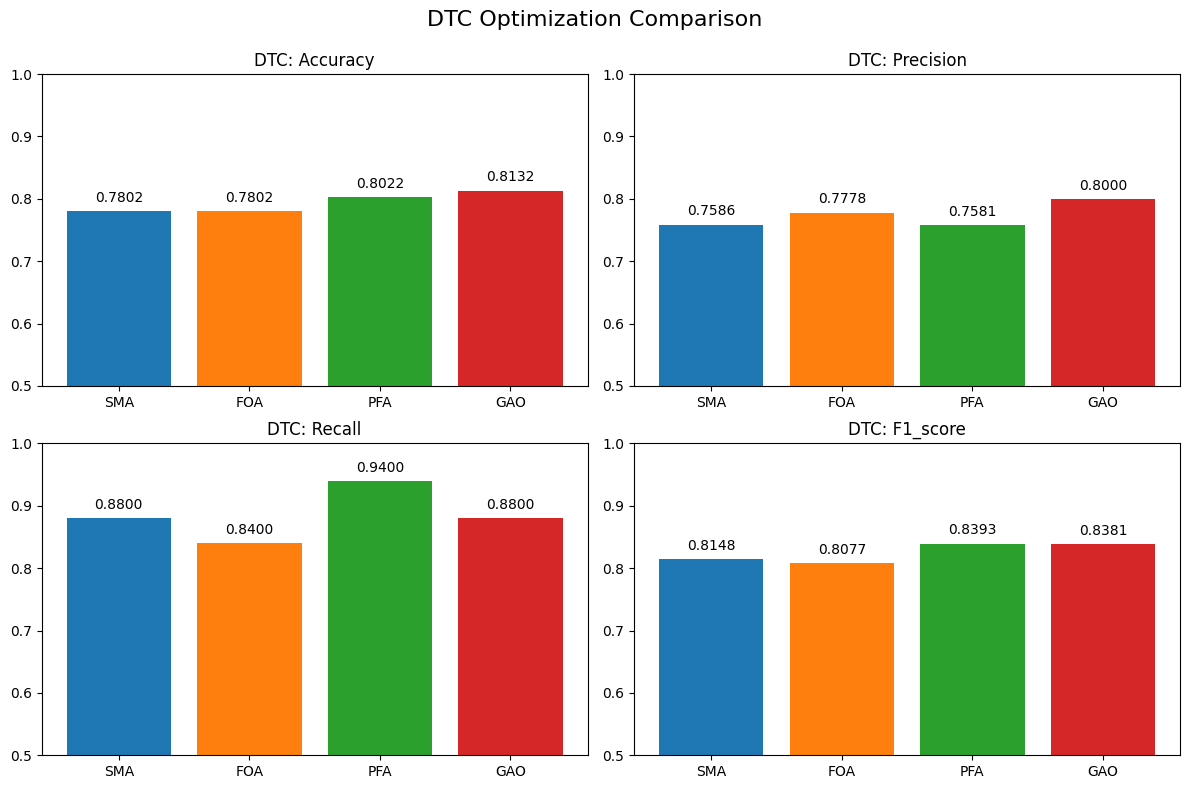

Optimization Results Summary:
--------------------------------------------------------------------------------
Optimizer  | Accuracy   | Precision  | Recall     | F1-score   | Parameters
--------------------------------------------------------------------------------
SMA        | 0.7802     | 0.7586     | 0.8800     | 0.8148     | {'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 5, 'criterion': 'entropy', 'splitter': 'random', 'max_features': np.float64(1.0), 'ccp_alpha': np.float64(0.05), 'class_weight': None, 'max_leaf_nodes': 20}
FOA        | 0.7802     | 0.7778     | 0.8400     | 0.8077     | {'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'entropy', 'splitter': 'random', 'max_features': np.float64(1.0), 'ccp_alpha': np.float64(0.007733907719840782), 'class_weight': 'balanced', 'max_leaf_nodes': 33}
PFA        | 0.8022     | 0.7581     | 0.9400     | 0.8393     | {'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': '

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 1. Load data
df = pd.read_csv('heart-disease.csv')

# 2. Prepare features and target (drop columns as in your reference)
X = df.drop(['target', 'restecg', 'sex', 'chol', 'fbs', 'trestbps', 'slope', 'exang'], axis=1)
y = df['target'].astype(int)

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 4. DTC parameter search space
dtc_space = {
    'max_depth': (3, 10),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 5),
    'criterion': (0, 1),        # 0=gini, 1=entropy
    'splitter': (0, 1),         # 0=best, 1=random
    'max_features': (0.5, 1.0), # fraction
    'ccp_alpha': (0.0, 0.05),
    'class_weight': (0, 1),     # 0=None, 1=balanced
    'max_leaf_nodes': (10, 50)
}

# 5. Helper: convert vector to DTC params
def convert_params(params):
    return {
        'max_depth': int(round(params[0])),
        'min_samples_split': int(round(params[1])),
        'min_samples_leaf': int(round(params[2])),
        'criterion': ['gini', 'entropy'][int(round(params[3]))],
        'splitter': ['best', 'random'][int(round(params[4]))],
        'max_features': params[5],
        'ccp_alpha': params[6],
        'class_weight': [None, 'balanced'][int(round(params[7]))],
        'max_leaf_nodes': int(round(params[8]))
    }

# 6. Objective function for optimization
def objective(params):
    clf = DecisionTreeClassifier(**convert_params(params), random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy').mean()

# 7. Metaheuristic optimizers

def SMA_optimization(search_space, max_iter=20):
    pop_size = 5
    population = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                          for _ in range(pop_size)])
    for iteration in range(max_iter):
        fitness = np.array([objective(ind) for ind in population])
        sorted_idx = np.argsort(-fitness)
        population = population[sorted_idx]
        a = np.arctanh(1 - (iteration+1)/max_iter)
        b = 1 - (iteration+1)/max_iter
        weights = 1 + np.random.rand() * np.log10((fitness[sorted_idx] - fitness.min()) /
                  (fitness.max() - fitness.min() + 1e-10) + 1)
        new_population = []
        for i in range(pop_size):
            if i < pop_size//2:
                new_pos = population[i] + a * (np.random.rand() * (population[0] - population[i]))
            else:
                new_pos = population[i] + b * (np.random.rand() * (population[i] - population[i-1]))
            new_population.append(np.clip(new_pos, [v[0] for v in search_space.values()],
                                         [v[1] for v in search_space.values()]))
        population = np.array(new_population)
    best_idx = np.argmax([objective(ind) for ind in population])
    return population[best_idx]

def FOA_optimization(search_space, max_iter=20):
    num_trees = 5
    trees = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                     for _ in range(num_trees)])
    for _ in range(max_iter):
        fitness = np.array([objective(ind) for ind in trees])
        best_idx = np.argmax(fitness)
        new_trees = []
        for tree in trees:
            if objective(tree) < np.median(fitness):
                new_trees.append(tree + np.random.normal(0, 0.1, size=len(search_space)))
            else:
                new_trees.append(tree)
        new_trees.append(trees[best_idx] + np.random.normal(0, 0.05, size=len(search_space)))
        trees = np.clip(new_trees, [v[0] for v in search_space.values()],
                       [v[1] for v in search_space.values()])
    best_idx = np.argmax([objective(ind) for ind in trees])
    return trees[best_idx]

def PFA_optimization(search_space, max_iter=20):
    group_size = 5
    group = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                     for _ in range(group_size)])
    leader = group[np.argmax([objective(ind) for ind in group])]
    for _ in range(max_iter):
        new_group = []
        for member in group:
            if np.array_equal(member, leader):
                new_pos = member + np.random.rand() * (leader - member)
            else:
                new_pos = member + 2*np.random.rand()*(leader - member) + \
                         np.random.rand()*(member - leader)
            new_group.append(new_pos)
        group = np.clip(new_group, [v[0] for v in search_space.values()],
                       [v[1] for v in search_space.values()])
        current_leader = group[np.argmax([objective(ind) for ind in group])]
        if objective(current_leader) > objective(leader):
            leader = current_leader
    return leader

def GAO_optimization(search_space, max_iter=20):
    pop_size = 5
    population = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                          for _ in range(pop_size)])
    for _ in range(max_iter):
        fitness = np.array([objective(ind) for ind in population])
        for i in range(pop_size):
            if np.random.rand() < 0.5:
                population[i] += np.random.normal(0, 0.1, size=len(search_space))
        best_idx = np.argmax(fitness)
        for i in range(pop_size):
            if i != best_idx:
                population[i] += np.random.rand() * (population[best_idx] - population[i])
        population = np.clip(population, [v[0] for v in search_space.values()],
                            [v[1] for v in search_space.values()])
    best_idx = np.argmax([objective(ind) for ind in population])
    return population[best_idx]

# 8. Run all optimizations and evaluate
optimizers = {
    'SMA': SMA_optimization,
    'FOA': FOA_optimization,
    'PFA': PFA_optimization,
    'GAO': GAO_optimization
}

results = {}
plt.figure(figsize=(8, 6))  # For ROC curves

for name, optimizer in optimizers.items():
    print(f"Optimizing DTC with {name}...")
    best_params = optimizer(dtc_space)
    dtc = DecisionTreeClassifier(**convert_params(best_params), random_state=42)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_test)
    y_proba = dtc.predict_proba(X_test)[:, 1]  # <-- Get positive class probability

    # Calculate metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)       # <-- Compute AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)   # <-- Compute ROC curve

    results[name] = {
        'params': convert_params(best_params),
        'accuracy': accuracy,
        'precision': report['1']['precision'],
        'recall': report['1']['recall'],
        'f1_score': report['1']['f1-score'],
        'auc': auc
    }

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {report['1']['precision']:.4f}")
    print(f"  Recall: {report['1']['recall']:.4f}")
    print(f"  F1-score: {report['1']['f1-score']:.4f}")
    print(f"  AUC: {auc:.4f}")                # <-- Print AUC
    print(f"  Parameters: {results[name]['params']}\n")

    # --- Plot ROC curve for this optimizer ---
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC={auc:.3f})')

# --- Finalize ROC plot ---
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree (All Optimizers)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 9. Plot results
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
optimizer_names = list(results.keys())
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()
for i, metric in enumerate(metrics):
    values = [results[name][metric] for name in optimizer_names]
    bars = axs[i].bar(optimizer_names, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    axs[i].set_title(f'DTC: {metric.capitalize()}')
    axs[i].set_ylim(0.5, 1.0)
    for bar in bars:
        height = bar.get_height()
        axs[i].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')
plt.tight_layout()
plt.suptitle('DTC Optimization Comparison', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# 10. Print summary table
print("Optimization Results Summary:")
print("-" * 80)
print(f"{'Optimizer':<10} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10} | {'F1-score':<10} | Parameters")
print("-" * 80)
for name in optimizer_names:
    params_str = str(results[name]['params'])
    print(f"{name:<10} | {results[name]['accuracy']:<10.4f} | "
          f"{results[name]['precision']:<10.4f} | {results[name]['recall']:<10.4f} | "
          f"{results[name]['f1_score']:<10.4f} | {params_str}")


## RFC

Optimizing RFC with SMA...
Optimizing RFC with FOA...
Optimizing RFC with PFA...
Optimizing RFC with GAO...


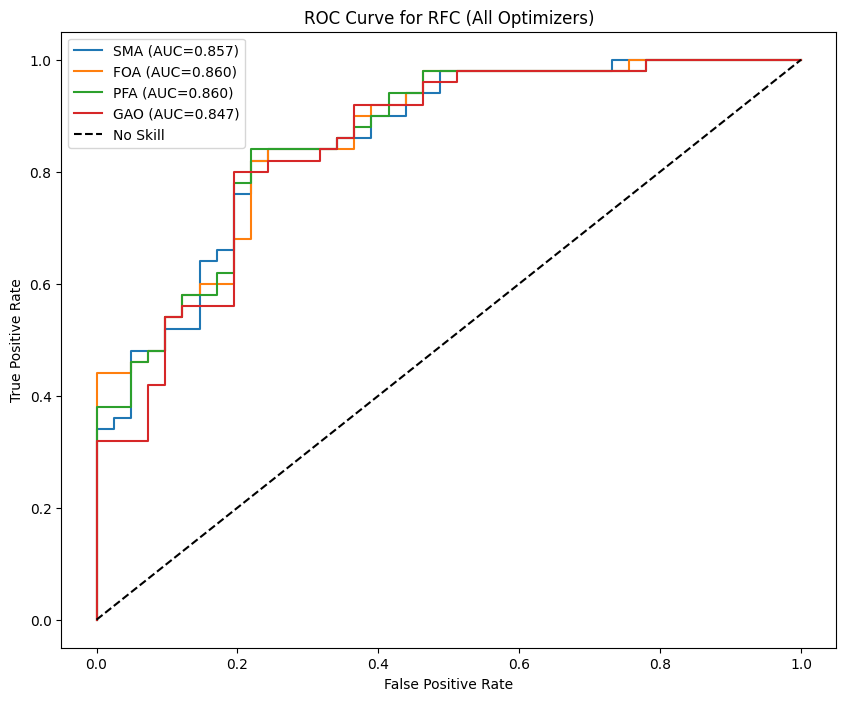

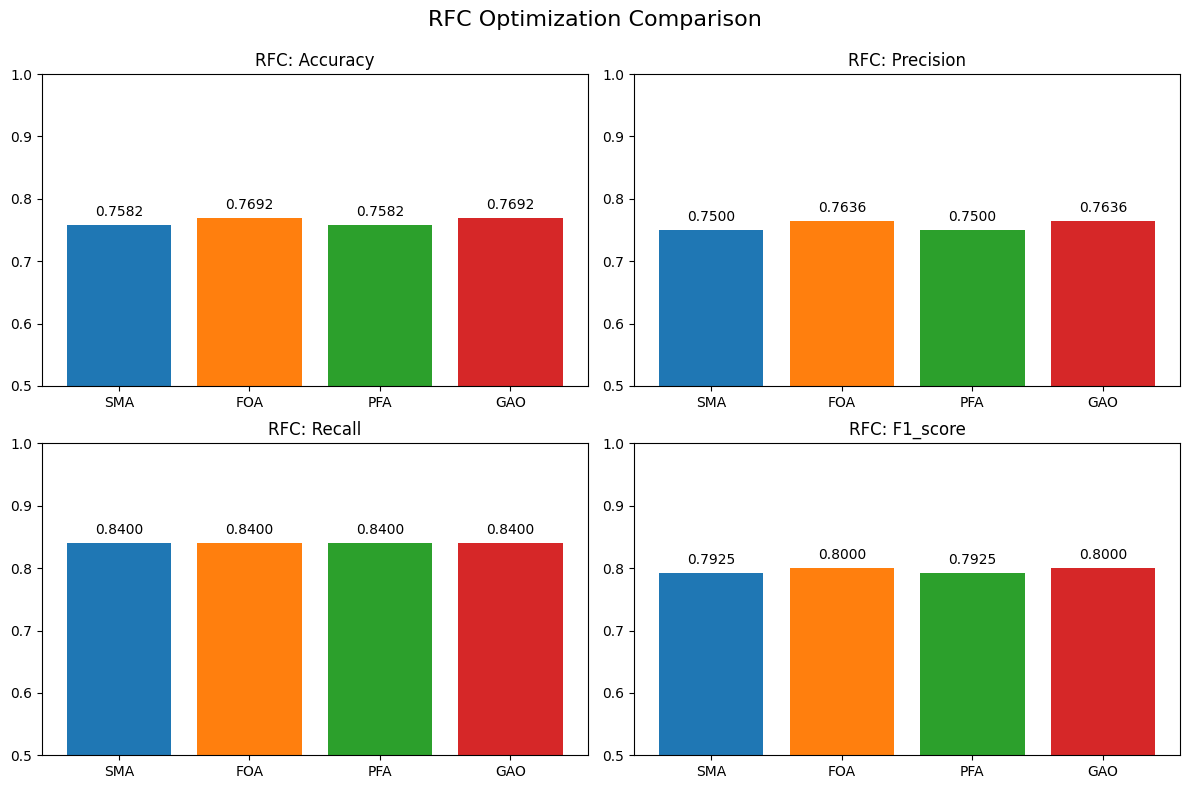

Optimization Results Summary:
--------------------------------------------------------------------------------
Optimizer  | Accuracy   | Precision  | Recall     | F1-score   | Parameters
--------------------------------------------------------------------------------
SMA        | 0.7582     | 0.7500     | 0.8400     | 0.7925     | {'n_estimators': 133, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': np.float64(0.5647575556029094), 'bootstrap': True, 'criterion': 'entropy', 'class_weight': None, 'random_state': 42}
FOA        | 0.7692     | 0.7636     | 0.8400     | 0.8000     | {'n_estimators': 158, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': np.float64(0.5814848042621763), 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'random_state': 42}
PFA        | 0.7582     | 0.7500     | 0.8400     | 0.7925     | {'n_estimators': 115, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_featur

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score

import matplotlib.pyplot as plt

# 1. Load data
df = pd.read_csv('heart-disease.csv')

# 2. Prepare features and target (drop columns as in your reference)
X = df.drop(['target', 'restecg', 'sex', 'chol', 'fbs', 'trestbps', 'slope', 'exang'], axis=1)
y = df['target'].astype(int)

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 4. RFC parameter search space
rfc_space = {
    'n_estimators': (50, 200),
    'max_depth': (3, 12),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 5),
    'max_features': (0.5, 1.0),  # fraction of features
    'bootstrap': (0, 1),         # 0=False, 1=True
    'criterion': (0, 1),         # 0='gini', 1='entropy'
    'class_weight': (0, 1)       # 0=None, 1='balanced'
}

# 5. Helper: convert vector to RFC params
def convert_params(params):
    return {
        'n_estimators': int(round(params[0])),
        'max_depth': int(round(params[1])),
        'min_samples_split': int(round(params[2])),
        'min_samples_leaf': int(round(params[3])),
        'max_features': params[4],
        'bootstrap': [False, True][int(round(params[5]))],
        'criterion': ['gini', 'entropy'][int(round(params[6]))],
        'class_weight': [None, 'balanced'][int(round(params[7]))],
        'random_state': 42
    }

# 6. Objective function for optimization
def objective(params):
    clf = RandomForestClassifier(**convert_params(params))
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy').mean()

# 7. Metaheuristic optimizers

def SMA_optimization(search_space, max_iter=20):
    pop_size = 5
    population = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                          for _ in range(pop_size)])
    for iteration in range(max_iter):
        fitness = np.array([objective(ind) for ind in population])
        sorted_idx = np.argsort(-fitness)
        population = population[sorted_idx]
        a = np.arctanh(1 - (iteration+1)/max_iter)
        b = 1 - (iteration+1)/max_iter
        weights = 1 + np.random.rand() * np.log10((fitness[sorted_idx] - fitness.min()) /
                  (fitness.max() - fitness.min() + 1e-10) + 1)
        new_population = []
        for i in range(pop_size):
            if i < pop_size//2:
                new_pos = population[i] + a * (np.random.rand() * (population[0] - population[i]))
            else:
                new_pos = population[i] + b * (np.random.rand() * (population[i] - population[i-1]))
            new_population.append(np.clip(new_pos, [v[0] for v in search_space.values()],
                                         [v[1] for v in search_space.values()]))
        population = np.array(new_population)
    best_idx = np.argmax([objective(ind) for ind in population])
    return population[best_idx]

def FOA_optimization(search_space, max_iter=20):
    num_trees = 5
    trees = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                     for _ in range(num_trees)])
    for _ in range(max_iter):
        fitness = np.array([objective(ind) for ind in trees])
        best_idx = np.argmax(fitness)
        new_trees = []
        for tree in trees:
            if objective(tree) < np.median(fitness):
                new_trees.append(tree + np.random.normal(0, 0.1, size=len(search_space)))
            else:
                new_trees.append(tree)
        new_trees.append(trees[best_idx] + np.random.normal(0, 0.05, size=len(search_space)))
        trees = np.clip(new_trees, [v[0] for v in search_space.values()],
                       [v[1] for v in search_space.values()])
    best_idx = np.argmax([objective(ind) for ind in trees])
    return trees[best_idx]

def PFA_optimization(search_space, max_iter=20):
    group_size = 5
    group = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                     for _ in range(group_size)])
    leader = group[np.argmax([objective(ind) for ind in group])]
    for _ in range(max_iter):
        new_group = []
        for member in group:
            if np.array_equal(member, leader):
                new_pos = member + np.random.rand() * (leader - member)
            else:
                new_pos = member + 2*np.random.rand()*(leader - member) + \
                         np.random.rand()*(member - leader)
            new_group.append(new_pos)
        group = np.clip(new_group, [v[0] for v in search_space.values()],
                       [v[1] for v in search_space.values()])
        current_leader = group[np.argmax([objective(ind) for ind in group])]
        if objective(current_leader) > objective(leader):
            leader = current_leader
    return leader

def GAO_optimization(search_space, max_iter=20):
    pop_size = 5
    population = np.array([[np.random.uniform(low, high) for (low, high) in search_space.values()]
                          for _ in range(pop_size)])
    for _ in range(max_iter):
        fitness = np.array([objective(ind) for ind in population])
        for i in range(pop_size):
            if np.random.rand() < 0.5:
                population[i] += np.random.normal(0, 0.1, size=len(search_space))
        best_idx = np.argmax(fitness)
        for i in range(pop_size):
            if i != best_idx:
                population[i] += np.random.rand() * (population[best_idx] - population[i])
        population = np.clip(population, [v[0] for v in search_space.values()],
                            [v[1] for v in search_space.values()])
    best_idx = np.argmax([objective(ind) for ind in population])
    return population[best_idx]

# 8. Run all optimizations and evaluate
optimizers = {
    'SMA': SMA_optimization,
    'FOA': FOA_optimization,
    'PFA': PFA_optimization,
    'GAO': GAO_optimization
}

results = {}
plt.figure(figsize=(10, 8))
for idx, (name, optimizer) in enumerate(optimizers.items()):
    print(f"Optimizing RFC with {name}...")
    best_params = optimizer(rfc_space)
    rfc = RandomForestClassifier(**convert_params(best_params))
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    y_proba = rfc.predict_proba(X_test)[:, 1]
    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    results[name] = {
        'params': convert_params(best_params),
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': report['1']['precision'],
        'recall': report['1']['recall'],
        'f1_score': report['1']['f1-score'],
        'auc': auc
    }
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RFC (All Optimizers)')
plt.legend()
plt.show()

# 9. Plot results
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
optimizer_names = list(results.keys())
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()
for i, metric in enumerate(metrics):
    values = [results[name][metric] for name in optimizer_names]
    bars = axs[i].bar(optimizer_names, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    axs[i].set_title(f'RFC: {metric.capitalize()}')
    axs[i].set_ylim(0.5, 1.0)
    for bar in bars:
        height = bar.get_height()
        axs[i].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')
plt.tight_layout()
plt.suptitle('RFC Optimization Comparison', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# 10. Print summary table
print("Optimization Results Summary:")
print("-" * 80)
print(f"{'Optimizer':<10} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10} | {'F1-score':<10} | Parameters")
print("-" * 80)
for name in optimizer_names:
    params_str = str(results[name]['params'])
    print(f"{name:<10} | {results[name]['accuracy']:<10.4f} | "
          f"{results[name]['precision']:<10.4f} | {results[name]['recall']:<10.4f} | "
          f"{results[name]['f1_score']:<10.4f} | {params_str}")
